In [126]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
import cv2 as cv

import h5py
import pickle
import os
import glob

# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.datafolders as df
import icewave.tools.matlab2python as mat2py
import icewave.tools.matlab_colormaps as matcmaps
import icewave.sebastien.set_graphs as set_graphs
import icewave.tools.Fourier_tools as FT
import icewave.drone.drone_projection as dp
import icewave.tools.rw_data as rw

# PARULA COLORMAP 
parula_map = matcmaps.parula()

full_blues = mpl.colormaps['Blues'].resampled(256)
new_blues = colors.ListedColormap(full_blues(np.linspace(0.2,1,256)))

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [130]:
base = 'F:/Rimouski_2025/Data/'
date = '0214'
drone_ID = 'bernache'
exp_ID = '05-waves_003'
suffixe = f'{date}_{drone_ID}_{exp_ID}'

fig_folder = f'{base}{date}/Drones/{drone_ID}/matData/{exp_ID}/Figures/'
if not os.path.isdir(fig_folder):
    os.mkdir(fig_folder)


In [128]:
path2data = f'{base}{date}/Drones/{drone_ID}/matData/{exp_ID}/'
filelist = glob.glob(f'{path2data}*scaled.mat')
print(filelist)

idx_file = 0
file2load = filelist[idx_file]

# load file 
with h5py.File(file2load, 'r') as fmat:
    S = {}

    print('Top-level keys : ', list(fmat.keys()))

    S = mat2py.mat_to_dict(fmat['m'],fmat['m'])
    S = mat2py.transpose_PIVmat_fields(S)

['F:/Rimouski_2025/Data/0214/Drones/mesange/matData/05-waves_003\\PIV_processed_i01050_N0_Dt4_b1_W32_xROI1_width3839_yROI1_height2159_scaled.mat']
Top-level keys :  ['#refs#', '#subsystem#', 'm']


In [15]:
S.keys()

dict_keys(['DRONE', 'GPS', 'ID', 'PIV_param', 'PIXEL', 'SCALE', 'UTC_t', 'Vx', 'Vy', 'Vz', 'X', 'Y', 'name', 't', 't0_UTC', 'units', 'x', 'xref', 'y', 'yref'])

### Flip velocity fields

In [129]:
Vx = FT.supress_quadratic_noise(np.transpose(S['Vx'],(1,0,2)),S['x'],S['y'])
Vy = FT.supress_quadratic_noise(np.transpose(S['Vy'],(1,0,2)),S['x'],S['y'])
Vx = np.transpose(Vx,(1,0,2))
Vy = np.transpose(Vy,(1,0,2))
# Vx = np.flip(S['Vx'],0)
# Vy = np.flip(S['Vy'],0)

# Vx = S['Vx']
# Vy = S['Vy']

Supressing quadratic noise...
Quadratic noise supressed
Supressing quadratic noise...
Quadratic noise supressed


### Show apparent fields $V_x$ and $V_y$

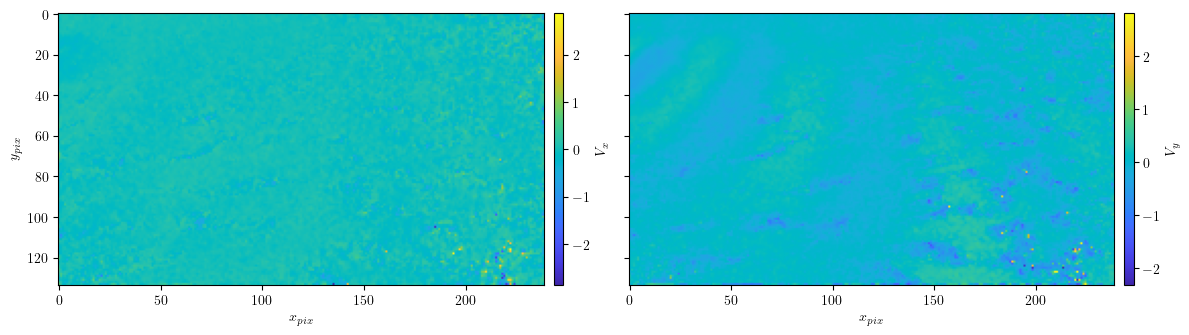

In [36]:
extents_pix = np.array([S['PIXEL']['x_pix'].min(),S['PIXEL']['x_pix'].max(),
                    S['PIXEL']['y_pix'].min(),S['PIXEL']['y_pix'].max()])

frame = 3600

fig, axs = plt.subplots(ncols = 2,sharey = True,figsize = (12,8))
imsh = []
for i,ax in enumerate(axs):
    if i == 0:
        imsh.append(ax.imshow(Vx[:,:,frame].T,cmap = parula_map))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cbar = plt.colorbar(imsh[i],cax = cax)
        cbar.set_label(r'$V_x$')
    else:
        imsh.append(ax.imshow(Vy[:,:,frame].T,cmap = parula_map))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cbar = plt.colorbar(imsh[i],cax = cax)
        cbar.set_label(r'$V_y$')
   
    ax.set_xlabel(r'$x_{pix}$')     

axs[0].set_ylabel(r'$y_{pix}$')

plt.tight_layout()

figname = f'{fig_folder}apparent_fields_Vx_Vy_{suffixe}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')

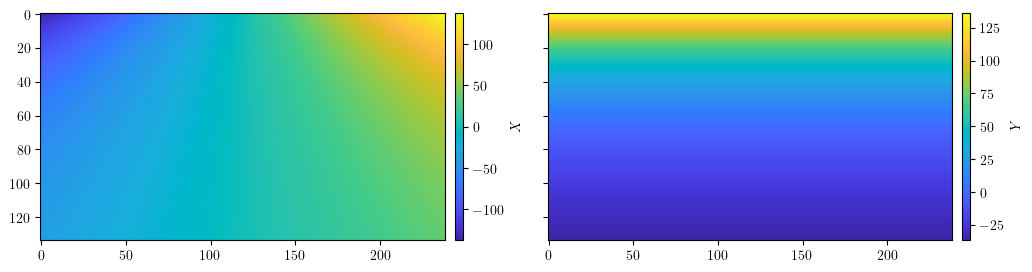

In [7]:
cmap = parula_map
fig, axs = plt.subplots(ncols = 2,sharey = True,figsize = (12,8))
imsh = []
for i,ax in enumerate(axs):
    if i == 0:
        imsh.append(ax.imshow(S['X'].T,cmap = cmap))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cbar = plt.colorbar(imsh[i],cax = cax)
        cbar.set_label(r'$X$')
    else:
        imsh.append(ax.imshow(S['Y'].T,cmap = cmap))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cbar = plt.colorbar(imsh[i],cax = cax)
        cbar.set_label(r'$Y$')


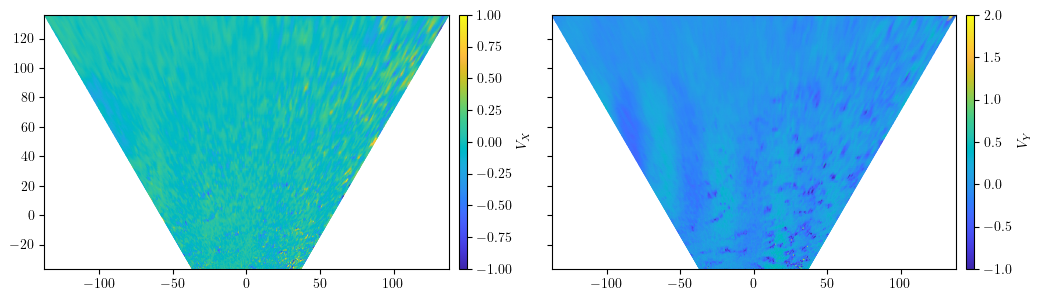

In [38]:
cmap = parula_map
frame = 3600

# axes limits
X_bounds = np.array([-50,50])
Y_bounds = np.array([-40,40])
Vx_values = np.array([-1,1])
Vy_values = np.array([-1,2])

fig, axs = plt.subplots(ncols = 2,sharey = True,figsize = (12,8))
imsh = []
for i,ax in enumerate(axs):
    if i == 0:
        imsh.append(ax.pcolormesh(S['X'],S['Y'],Vx[:,:,frame],shading = 'gouraud',cmap = cmap,
                                 vmin = Vx_values[0],vmax = Vx_values[1]))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cbar = plt.colorbar(imsh[i],cax = cax)
        cbar.set_label(r'$V_X$')
    else:
        imsh.append(ax.pcolormesh(S['X'],S['Y'],Vy[:,:,frame],shading = 'gouraud',cmap = cmap,
                                 vmin = Vy_values[0],vmax = Vy_values[1]))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cbar = plt.colorbar(imsh[i],cax = cax)
        cbar.set_label(r'$V_Y$')

    ax.set_aspect(1)
    # ax.set_xlim([X_bounds[0],X_bounds[1]])
    # ax.set_ylim([Y_bounds[0],Y_bounds[1]])

## Compute velocity fields $u_x$ and $u_z$

### Check values of $(\cos(\alpha) + \sin^2(\alpha)\frac{Y}{z^*})\frac{f}{z^*}$

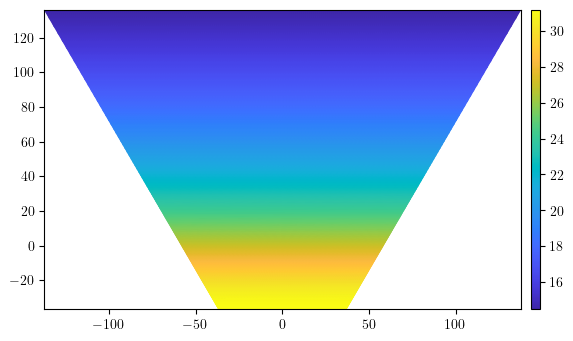

In [9]:
alpha = S['DRONE']['alpha_0']
h = S['DRONE']['h_drone']
f = S['DRONE']['focale']
Y = S['Y']
X = S['X']

z_star = dp.get_zstar(h,alpha,Y)

coeff = (np.cos(alpha) + (np.sin(alpha)**2)*Y/z_star)*f/z_star

fig, ax = plt.subplots()
imsh = ax.pcolormesh(S['X'],S['Y'],coeff,shading = 'gouraud',cmap = parula_map)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
ax.set_aspect(1)


### Try inversion of $u_z$

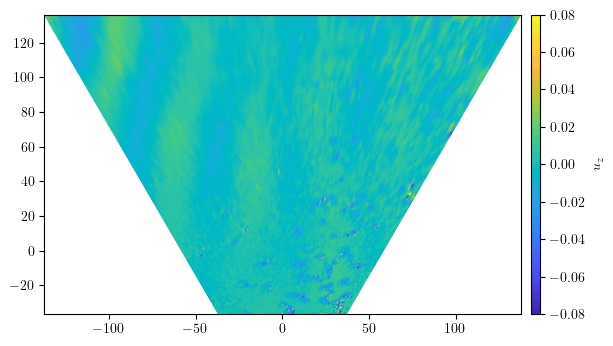

In [42]:
frame = 1
uz = Vy/coeff[:,:,None]

uz_values = np.array([-0.08,0.08])
fig, ax = plt.subplots()
imsh = ax.pcolormesh(S['X'],S['Y'],uz[:,:,frame],shading = 'gouraud',cmap = parula_map,
                    vmin = uz_values[0],vmax = uz_values[1])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_z$')
ax.set_aspect(1)

figname = f'{fig_folder}uz_georectified_{suffixe}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')

### Deduce $u_x$

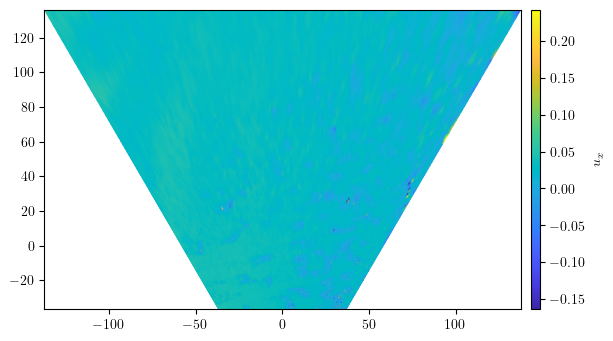

In [10]:
ux = Vx*z_star[:,:,None]/f - uz*np.sin(alpha)*X[:,:,None]/z_star[:,:,None] 

fig, ax = plt.subplots()
imsh = ax.pcolormesh(S['X'],S['Y'],ux[:,:,frame],shading = 'gouraud',cmap = parula_map)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_x$')
ax.set_aspect(1)

## Try to get spatial characteristics of apparent field $V_y$

### Define a regular grid

In [136]:
#%% Define grid 

minx = -65
maxx = 65
miny = 20
maxy = 110

artificial_facq_x = 1/0.6 # artificial spatial frequency in box/meter
grid_x, grid_y = np.meshgrid(
    np.linspace(minx, maxx, int((maxx - minx)*artificial_facq_x)),  
    np.linspace(miny, maxy, int((maxy - miny)*artificial_facq_x))
)

### Check selected region of the measured field

(20.0, 110.0)

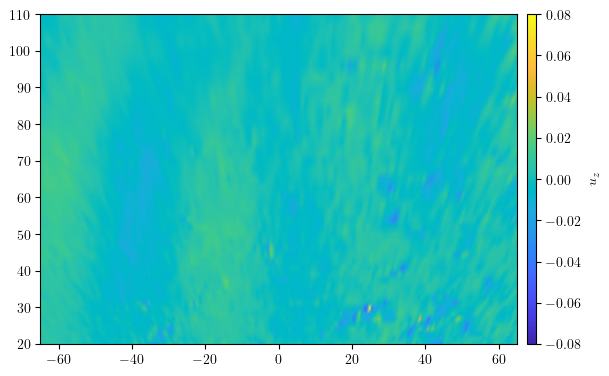

In [41]:
uz_values = np.array([-0.08,0.08])
fig, ax = plt.subplots()
imsh = ax.pcolormesh(S['X'],S['Y'],uz[:,:,frame],shading = 'gouraud',cmap = parula_map,
                    vmin = uz_values[0],vmax = uz_values[1])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_z$')
ax.set_aspect(1)

ax.set_xlim([minx,maxx])
ax.set_ylim([miny,maxy])

### Compare spatial sampling 

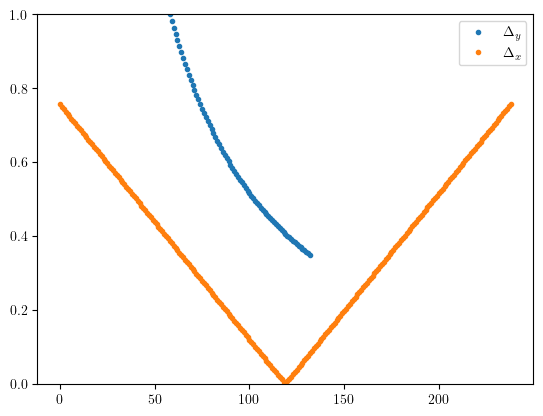

In [12]:
diff_y = np.diff(S['Y'][0,:])
diff_x = np.mean(np.diff(S['X'],axis = 1),axis = 1)


fig, ax = plt.subplots()
ax.plot(abs(diff_y),'.',label = '$\Delta_y$')
ax.plot(abs(diff_x),'.', label = '$\Delta_x$')
ax.set_ylim([0,1])
ax.legend()

### Interpolate field over a regular grid

In [21]:
grid_x.shape

(225, 400)

In [43]:
points = np.array([S['X'].ravel(),S['Y'].ravel()]).T
interp_uz = np.zeros((grid_x.shape[0],grid_x.shape[1],uz.shape[2]))
for frame in range(uz.shape[2]):
    print(frame)
    interp_uz[:,:,frame] = dp.interpolate_field(points,uz[:,:,frame],grid_x,grid_y) 
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [30]:
interp_uz[:,:,400]

array([[0.05604969, 0.05510723, 0.05434382, ..., 0.07285464, 0.07493127,
        0.07572575],
       [0.05573413, 0.05512971, 0.05474573, ..., 0.07292211, 0.07748538,
        0.07826186],
       [0.05539748, 0.05507187, 0.0553269 , ..., 0.07218955, 0.07737663,
        0.07993748],
       ...,
       [0.07755221, 0.07728692, 0.07836716, ..., 0.08224913, 0.07578612,
        0.0654514 ],
       [0.07776414, 0.07778158, 0.0790351 , ..., 0.08249689, 0.07605518,
        0.06630234],
       [0.07782431, 0.07827623, 0.07966989, ..., 0.08274465, 0.07632425,
        0.06770127]], shape=(150, 216))

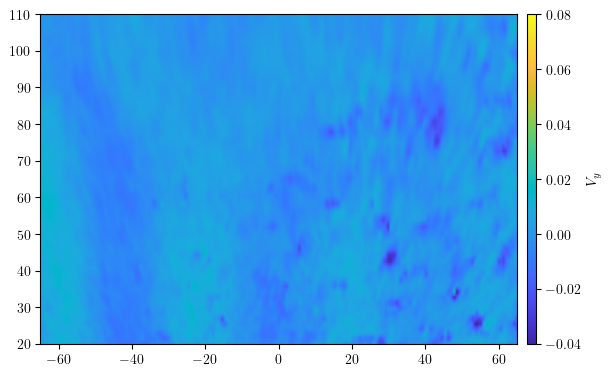

In [44]:
frame = 3600
fig, ax = plt.subplots()
imsh = ax.pcolormesh(grid_x.T,grid_y.T,interp_uz[:,:,frame].T,shading = 'gouraud',cmap = parula_map,
                    vmin = -0.04, vmax = 0.08)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$V_y$')
ax.set_aspect(1)

In [19]:
S.keys()

dict_keys(['DRONE', 'GPS', 'ID', 'PIV_param', 'PIXEL', 'SCALE', 'UTC_t', 'Vx', 'Vy', 'Vz', 'X', 'Y', 'name', 't', 't0_UTC', 'units', 'x', 'xref', 'y', 'yref'])

In [45]:
data = {}
data['DRONE'] = S['DRONE']
data['GPS'] = S['GPS']
data['uz'] = uz
data['interp_uz'] = interp_uz
data['grid_x'] = grid_x
data['grid_y'] = grid_y
data['SCALE'] = S['SCALE']
data['artificial_facq_x'] = artificial_facq_x
data['t'] = S['t']


In [46]:
file2save = f'{path2data}interpolated_uz_quadratic_correction{date}_{drone_ID}_{exp_ID}.h5'
rw.save_dict_to_h5(data, file2save)

### Load image and show selected field 

In [132]:
path2tiff = f'{base}{date}/Drones/{drone_ID}/{exp_ID}/'
filelist = glob.glob(f'{path2tiff}*.tiff')

file2read = filelist[0]
img = cv.imread(file2read)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

Xreal,Yreal = dp.georectify_image(img,S['DRONE']['h_drone'],S['DRONE']['alpha_0'],S['DRONE']['focale'])

### Show georectified image

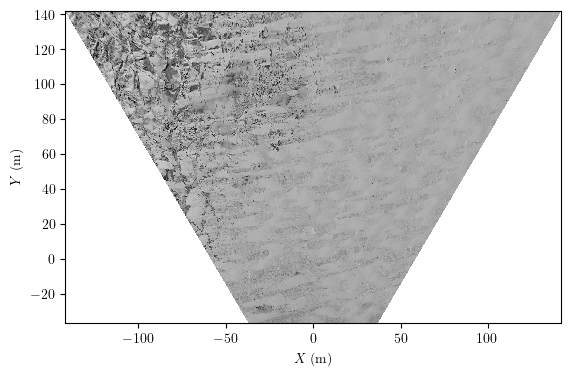

In [137]:
fig, ax = plt.subplots()

c = ax.pcolormesh(Xreal,Yreal,img[:,:,0],shading = 'auto', cmap = 'gray')
ax.set_xlabel(r'$X \; \mathrm{(m)}$',labelpad = 5)
ax.set_ylabel(r'$Y \; \mathrm{(m)}$',labelpad = 5)
ax.set_aspect(1) # set aspect ratio to 1 

### Show georectified image corresponding to selected regular grid

(20.0, 110.0)

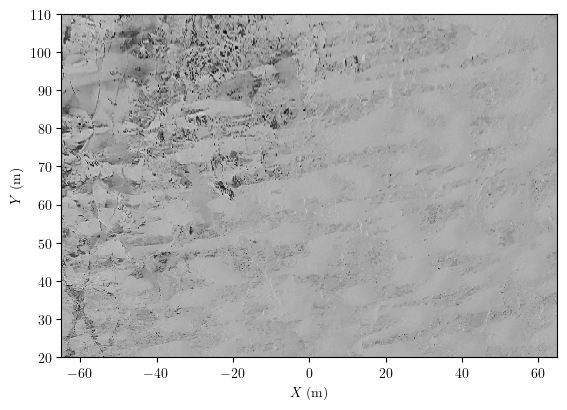

In [138]:
fig, ax = plt.subplots()

c = ax.pcolormesh(Xreal,Yreal,img[:,:,0],shading = 'auto', cmap = 'gray')
ax.set_xlabel(r'$X \; \mathrm{(m)}$',labelpad = 5)
ax.set_ylabel(r'$Y \; \mathrm{(m)}$',labelpad = 5)
ax.set_aspect(1) # set aspect ratio to 1 

ax.set_xlim([minx,maxx])
ax.set_ylim([miny,maxy])
# c.set_rasterized(True)